# Machine Learning Model for Predicting Term Deposit Subscriptions

In this project, we aim to build a model using the bank_marketing.csv dataset for predicting whether or not customers of a Portuguese banking institution will subscribe to a bank term deposit. 

This project is organized as follows: 
1. 
2. 
3. 

Authors:
- Gary Bair
- Jonathan Yoon
- Zachariah Freitas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

## Data Importing and Pre-processing

### Read Dataset and Display Columns

In [2]:
df = pd.read_csv('bank_marketing.csv', delimiter = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no


### Dataframe Dimensions

In [4]:
df.shape

(45211, 17)

We observe that our dataset contains 45,211 records with 17 features.

### Dataframe Data Types

In [5]:
df.dtypes

age          float64
job           object
marital       object
education     object
default       object
balance        int64
housing       object
loan          object
contact       object
day            int64
month         object
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
deposit       object
dtype: object

We observe that the binary and categorical variables in our dataset were interpreted as strings. These variables will likely need to be recast for further analysis

### Checking Data Integrity

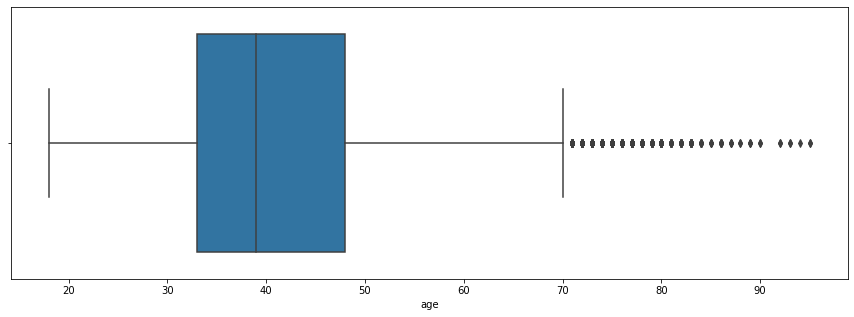

In [6]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "age")

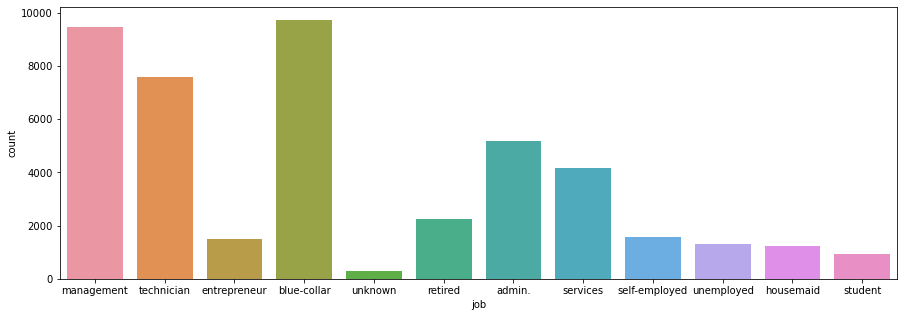

In [7]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data = df, x ='job')

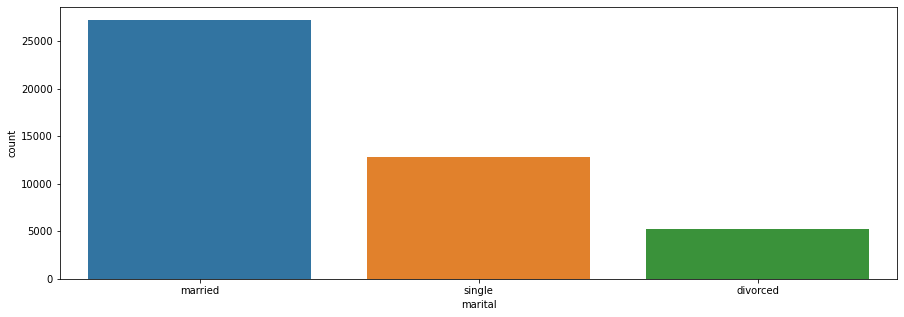

In [8]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='marital')

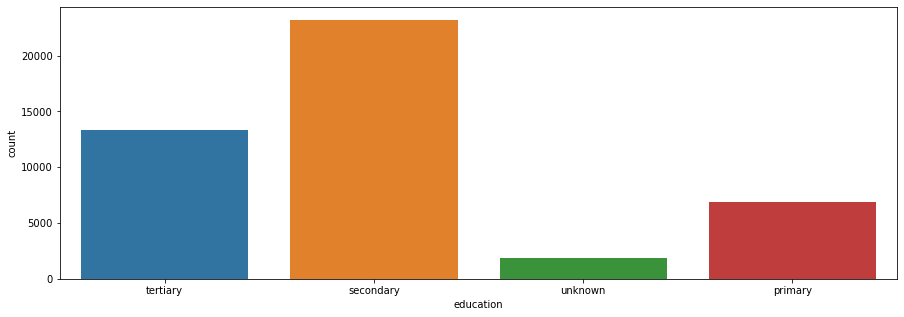

In [9]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='education')

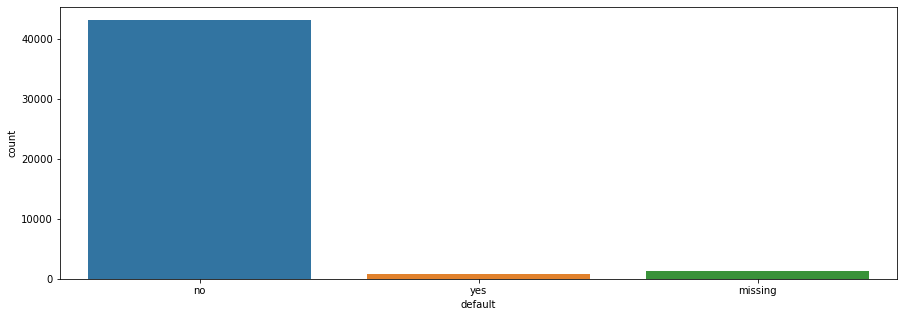

In [34]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='default')

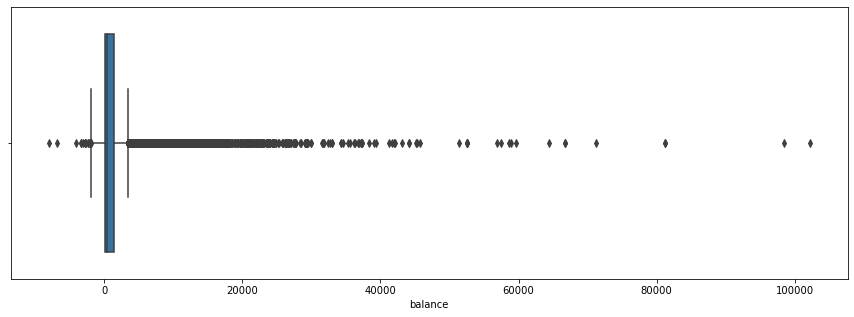

In [11]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "balance")

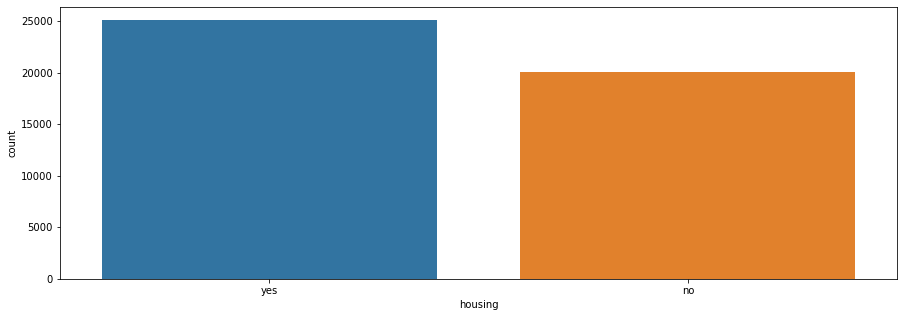

In [12]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='housing')

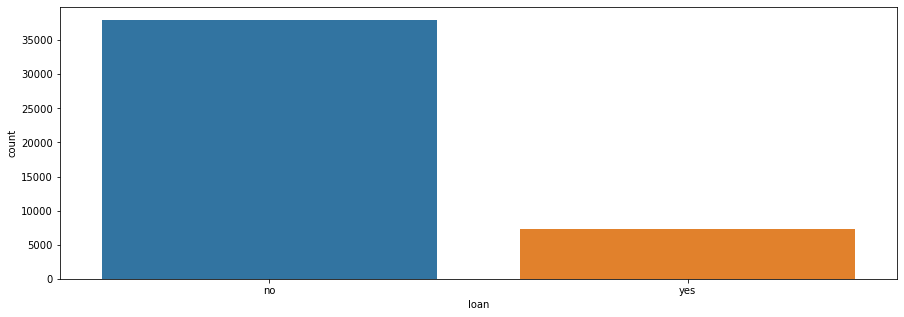

In [13]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='loan')

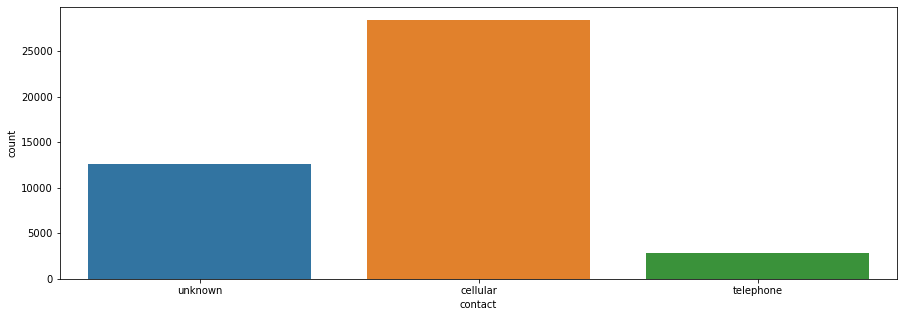

In [14]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='contact')

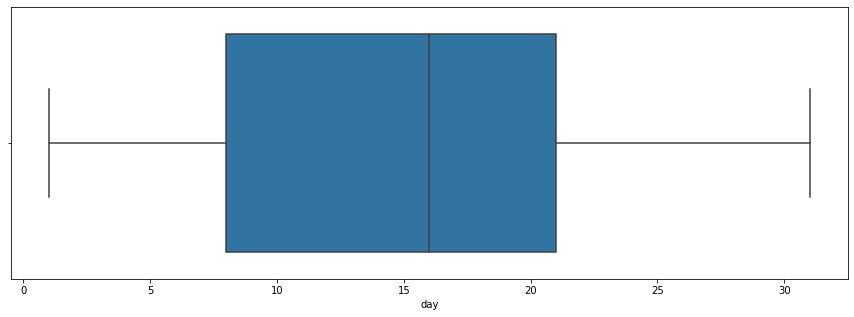

In [15]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "day")

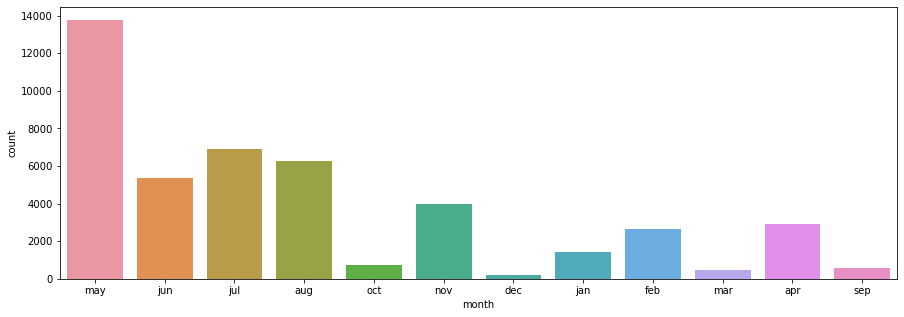

In [16]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='month')

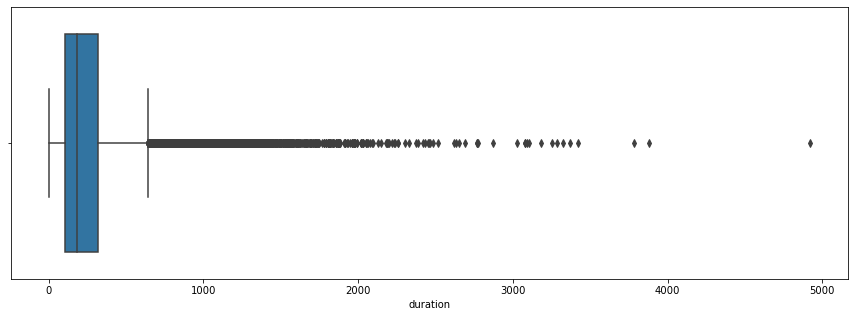

In [17]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "duration")

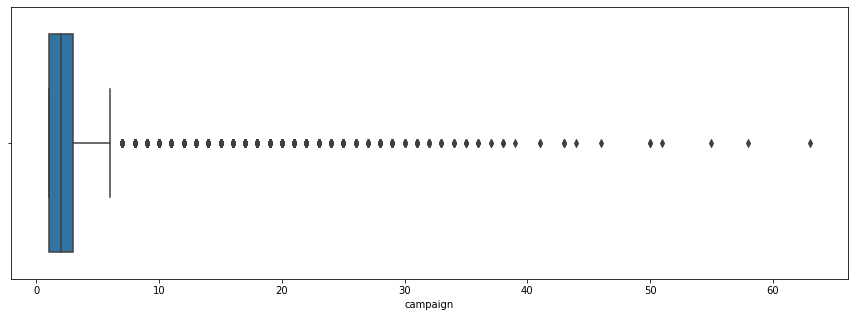

In [18]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "campaign")

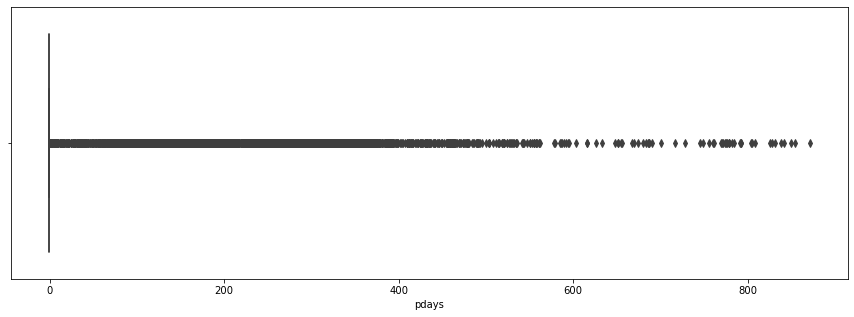

In [19]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "pdays")

Given the distribution of this feature, reencoding this variable to a binary outcome may be worth implementing.

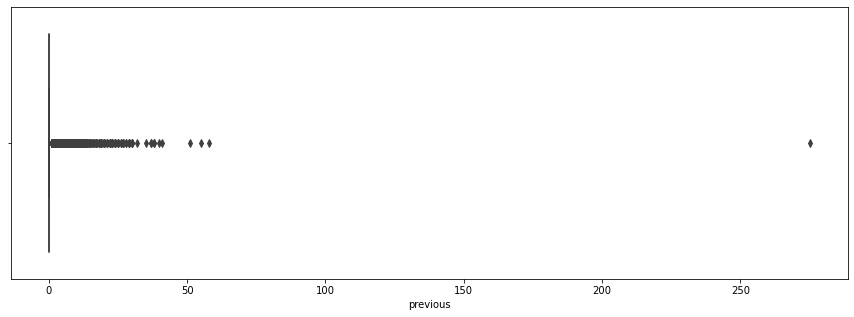

In [20]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data = df, x = "previous")

Given the distribution of this feature, reencoding this variable to a binary outcome may be worth implementing.

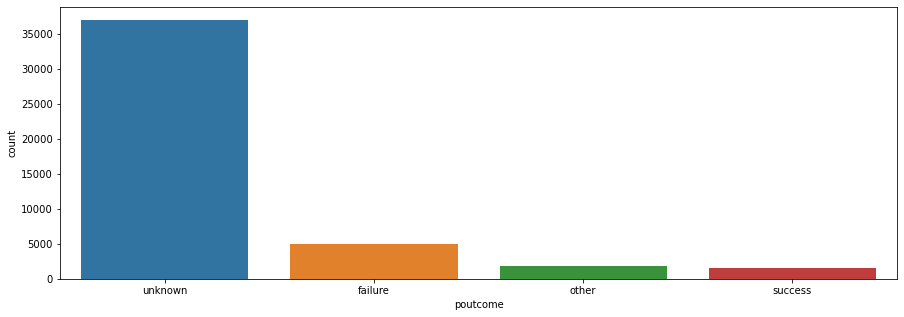

In [21]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='poutcome')

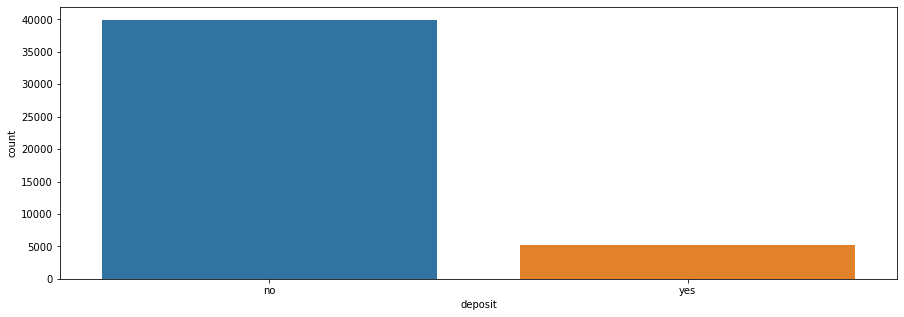

In [22]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='deposit')

### Finding Missing Data

In [23]:
df.isnull().sum()

age          1339
job             0
marital         0
education       0
default      1306
balance         0
housing         0
loan            0
contact      1383
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
deposit         0
dtype: int64

In [24]:
df.isnull().sum().sum()

4028

We note a total of 4,028 null values occuring across the features age, default, and contact.

### Imputing Missing Data -  Age

Given age is numeric and continuous, observing the distribution of values helps inform potential methods of imputation

In [25]:
df['age'].describe()

count    43872.000000
mean        40.924781
std         10.610835
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [26]:
df['age'].skew()

0.6852384774297872

Age as a feature appears to be symmetric enough that imputing via the mean or median appears to be a viable solution. For the remainder of our EDA, missing values in age will be imputed via the average with the intention implementing a machine learning method we establish a pipeline that can be validated.

In [27]:
df['age'].fillna(value=df['age'].mean(), inplace = True)

### Imputing Missing Data -  Default

Default is a categorical variable that is encoded as a string.

Default in the dataset documentation is defined as "default: has credit in default? (binary: "yes","no")." While we could take a frequency based approach and label missing values as 'no', this missingnesss could be a potential indicator thus we will encode it as 'unknown' until we validate this method.

In [28]:
df['default'].value_counts(dropna = False)

no     43113
NaN     1306
yes      792
Name: default, dtype: int64

In [29]:
df['default'].fillna(value= 'missing', inplace = True)

### Imputing Missing Data -  Contact

Contact is another categorical variable that is encoded as a string.

In [30]:
df['contact'].value_counts(dropna = False)

cellular     28410
unknown      12609
telephone     2809
NaN           1383
Name: contact, dtype: int64

Contact in the dataset documentation is defined as contact: contact communication type (categorical: "unknown","telephone","cellular)." We opt to take the same approach as the feature Default since it present a similiar situation.

In [31]:
df['contact'].fillna(value= 'missing', inplace = True)

### Transforming Data - Normalization

In [41]:
def z_score(df,col_list):
    for col in col_list:
        df['standardized_{}'.format(col)] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [43]:
z_columns = ['age', 'balance','day', 'duration','campaign']
df = z_score(df, z_columns)

In [44]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,deposit,standardized_age,standardized_balance,standardized_day,standardized_duration,standardized_campaign
0,1.633598,management,married,tertiary,no,0.256416,yes,no,unknown,-1.298462,...,-0.569344,-1,0,unknown,no,1.633598,0.256416,-1.298462,0.011016,-0.569344
1,0.294208,technician,single,secondary,no,-0.437890,yes,no,unknown,-1.298462,...,-0.569344,-1,0,unknown,no,0.294208,-0.437890,-1.298462,-0.416122,-0.569344
2,-0.758169,entrepreneur,married,secondary,no,-0.446758,yes,yes,unknown,-1.298462,...,-0.569344,-1,0,unknown,no,-0.758169,-0.446758,-1.298462,-0.707353,-0.569344
3,0.581220,blue-collar,married,unknown,no,0.047205,yes,no,unknown,-1.298462,...,-0.569344,-1,0,unknown,no,0.581220,0.047205,-1.298462,-0.645224,-0.569344
4,-0.758169,unknown,single,unknown,no,-0.447086,no,no,missing,-1.298462,...,-0.569344,-1,0,unknown,no,-0.758169,-0.447086,-1.298462,-0.233618,-0.569344


### Transforming Data - Feature Creation

In [49]:
df['binarized_pdays'] = df['pdays'].mask(df['pdays'] > 0, 'yes')
df['binarized_pdays'] = df['binarized_pdays'].where(df['pdays'] > 0, 'no')

In [51]:
df['binarized_previous'] = df['previous'].mask(df['previous'] > 0, 'yes')
df['binarized_previous'] = df['binarized_previous'].where(df['previous'] > 0, 'no')

In [52]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,previous,poutcome,deposit,standardized_age,standardized_balance,standardized_day,standardized_duration,standardized_campaign,binarized_pdays,binarized_previous
0,1.633598,management,married,tertiary,no,0.256416,yes,no,unknown,-1.298462,...,0,unknown,no,1.633598,0.256416,-1.298462,0.011016,-0.569344,no,no
1,0.294208,technician,single,secondary,no,-0.437890,yes,no,unknown,-1.298462,...,0,unknown,no,0.294208,-0.437890,-1.298462,-0.416122,-0.569344,no,no
2,-0.758169,entrepreneur,married,secondary,no,-0.446758,yes,yes,unknown,-1.298462,...,0,unknown,no,-0.758169,-0.446758,-1.298462,-0.707353,-0.569344,no,no
3,0.581220,blue-collar,married,unknown,no,0.047205,yes,no,unknown,-1.298462,...,0,unknown,no,0.581220,0.047205,-1.298462,-0.645224,-0.569344,no,no
4,-0.758169,unknown,single,unknown,no,-0.447086,no,no,missing,-1.298462,...,0,unknown,no,-0.758169,-0.447086,-1.298462,-0.233618,-0.569344,no,no


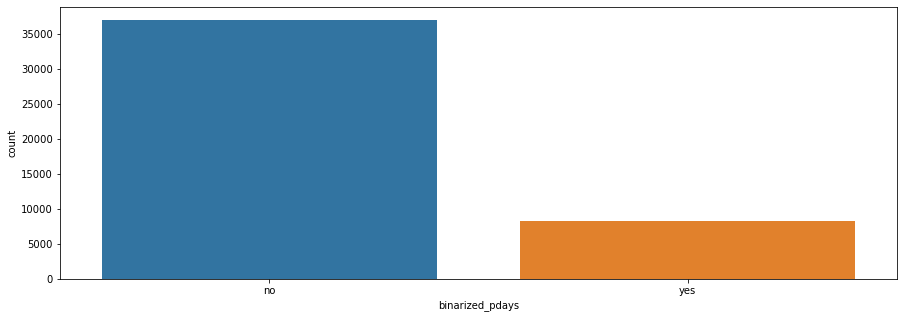

In [53]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='binarized_pdays')

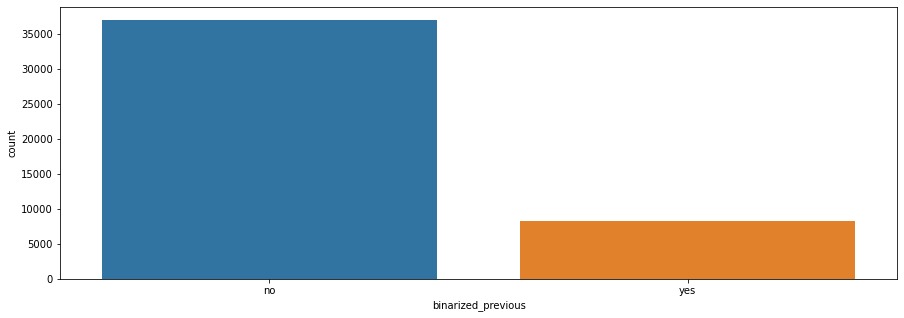

In [55]:
plt.figure(figsize=(15,5))
ax = sns.countplot(data=df, x='binarized_previous')

## Data Analysis and Visualization

### Univariate Analysis

In [32]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.452521,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [33]:
df.skew()

age          0.695616
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64

Investigating the summary statistics of our dataset yield a few irregularities for the features balance, pdays, and previous. Plotting these variables yeilds.

In [8]:
df.groupby('deposit').size()

deposit
no     39922
yes     5289
dtype: int64

<AxesSubplot:>

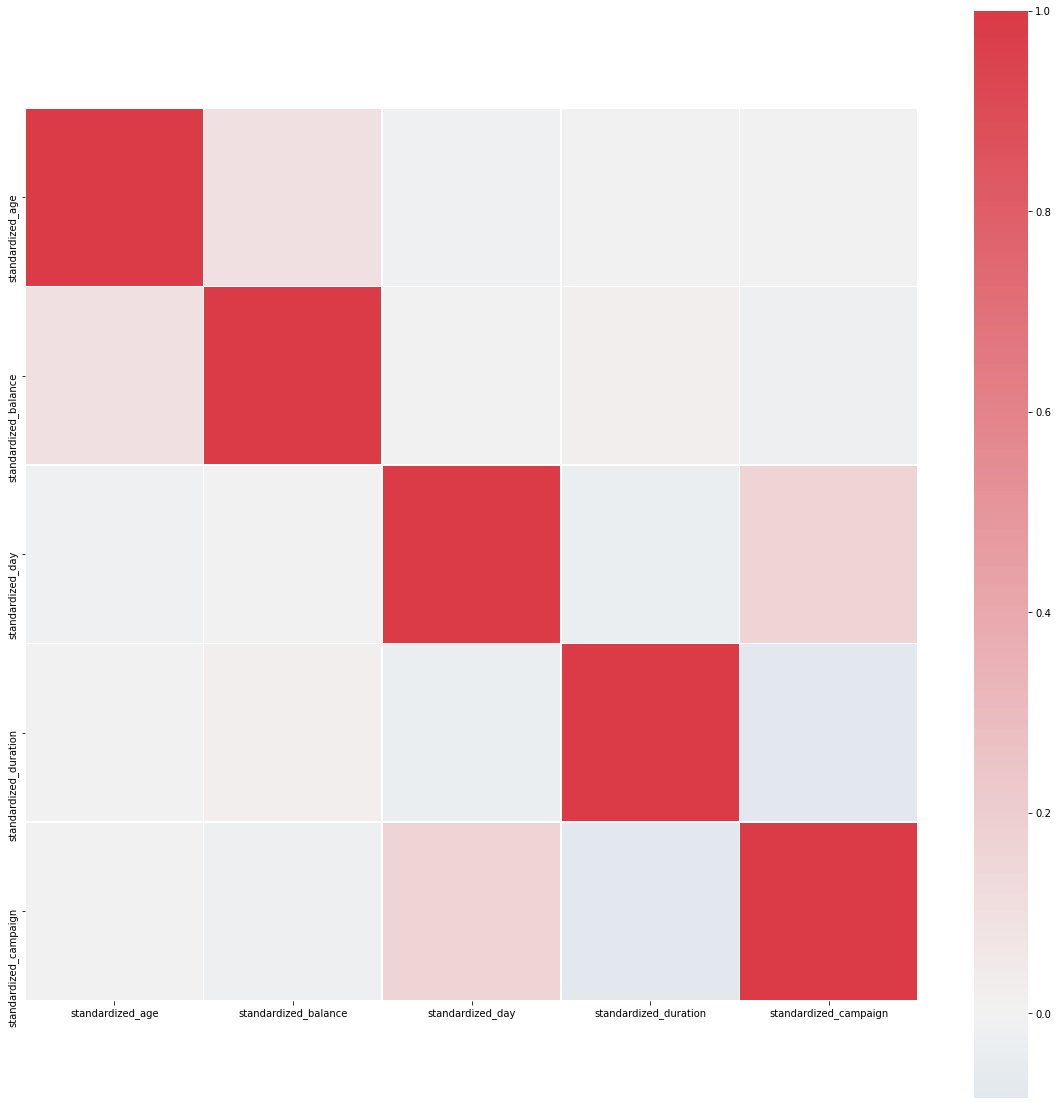

In [61]:
correlation = df.loc[:, 'standardized_age':'standardized_campaign'].corr()
f, x = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(correlation, cmap=cmap, center=0, square=True, linewidths=.5)

In [63]:
df.corr()

,age,balance,day,duration,campaign,pdays,previous,standardized_age,standardized_balance,standardized_day,standardized_duration,standardized_campaign
age,1.000000,0.096673,-0.008720,-0.003115,0.004858,-0.021818,0.001432,1.000000,0.096673,-0.008720,-0.003115,0.004858
balance,0.096673,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.096673,1.000000,0.004503,0.021560,-0.014578
day,-0.008720,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.008720,0.004503,1.000000,-0.030206,0.162490
duration,-0.003115,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,-0.003115,0.021560,-0.030206,1.000000,-0.084570
campaign,0.004858,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,0.004858,-0.014578,0.162490,-0.084570,1.000000
pdays,-0.021818,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,-0.021818,0.003435,-0.093044,-0.001565,-0.088628
previous,0.001432,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.001432,0.016674,-0.051710,0.001203,-0.032855
standardized_age,1.000000,0.096673,-0.008720,-0.003115,0.004858,-0.021818,0.001432,1.000000,0.096673,-0.008720,-0.003115,0.004858
standardized_balance,0.096673,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.096673,1.000000,0.004503,0.021560,-0.014578
standardized_day,-0.008720,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.008720,0.004503,1.000000,-0.030206,0.162490
